<a href="https://colab.research.google.com/github/PrabhuRS1397/DA_18_Task/blob/main/House_price_predication__Final_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
sns.set_style('dark')
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2, f_regression
from scipy.stats import pearsonr
from scipy import stats
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# House Price Predication

## Problem statement
Real estate transactions are quite opaque sometimes and it may be difficult for a newbie to know the fair price of any given home. Thus, multiple real estate websites have the functionality to predict the prices of houses given different features regarding it. Such forecasting models will help buyers to identify a fair price for the home and also give insights to sellers as to how to build homes that fetch them more money. Chennai house sale price data is shared here and the participants are expected to build a sale price prediction model that will aid the customers to find a fair price for their homes and also help the sellers understand what factors are fetching more money for the houses?

In [14]:
df=pd.read_csv('/content/train-chennai-sale.csv')

Removing non-Features

In [15]:
df= df.drop(['PRT_ID','QS_ROOMS','QS_BATHROOM','QS_BEDROOM','QS_OVERALL','REG_FEE','COMMIS'],axis=1)

In [16]:
print("Total number of features in the data is:",df.shape[1])
pd.DataFrame(df.dtypes.value_counts()).T

Total number of features in the data is: 16


,object,int64,float64
0,9,5,2


In [17]:
categorical_features = [x for x in df.columns 
                if not (df[x].dtype == np.float64 
                        or df[x].dtype == np.int64)]
print(categorical_features)

['AREA', 'DATE_SALE', 'SALE_COND', 'PARK_FACIL', 'DATE_BUILD', 'BUILDTYPE', 'UTILITY_AVAIL', 'STREET', 'MZZONE']


In [18]:
numerical_features=[x for x in df.columns if df[x].dtype==np.int64 or df[x].dtype==np.float64]
print(numerical_features)

['INT_SQFT', 'DIST_MAINROAD', 'N_BEDROOM', 'N_BATHROOM', 'N_ROOM', 'SALES_PRICE', 'Age(Years)']


In [19]:
pd.DataFrame(df.isnull().sum()).T

,AREA,INT_SQFT,DATE_SALE,DIST_MAINROAD,N_BEDROOM,N_BATHROOM,N_ROOM,SALE_COND,PARK_FACIL,DATE_BUILD,BUILDTYPE,UTILITY_AVAIL,STREET,MZZONE,SALES_PRICE,Age(Years)
0,0,0,0,0,1,5,0,0,0,0,0,0,0,0,0,0


Filling values

In [21]:
df['N_BEDROOM']=df['N_BEDROOM'].fillna(df['N_BEDROOM'].mean())
df['N_BATHROOM']=df['N_BATHROOM'].fillna(df['N_BATHROOM'].mean())
df['N_BEDROOM'] = np.floor(df['N_BEDROOM'])
df['N_BATHROOM'] = np.floor(df['N_BATHROOM'])

In [22]:
pd.DataFrame(df.isnull().sum()).T

,AREA,INT_SQFT,DATE_SALE,DIST_MAINROAD,N_BEDROOM,N_BATHROOM,N_ROOM,SALE_COND,PARK_FACIL,DATE_BUILD,BUILDTYPE,UTILITY_AVAIL,STREET,MZZONE,SALES_PRICE,Age(Years)
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Spelling Correction-Data Cleaning

In [23]:
df['PARK_FACIL'].replace(['Noo'],['No'],inplace=True)
df['STREET'].replace(['Pavd','NoAccess'],['Paved','No Access'],inplace=True)
df['UTILITY_AVAIL'].replace(['NoSewr ','NoSeWa','All Pub'],['No Sewer','No Sewer','AllPub'],inplace=True)
df['BUILDTYPE'].replace(['Comercial','Other'],['Commercial','Others'],inplace=True)
df['SALE_COND'].replace(['Ab Normal','Partiall','PartiaLl','Adj Land'],['AbNormal','Partial','Partial','AdjLand'],inplace=True)
df['AREA'].replace(['Ana Nagar','Ann Nagar','Karapakam','Chrompt','Chrmpet','Chormpet','Adyr','Velchery','KKNagar','TNagar'],
['Anna Nagar','Anna Nagar','Karapakkam','Chrompet','Chrompet','Chrompet','Adyar','Velachery','KK Nagar','T Nagar'],
inplace=True)

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7109 entries, 0 to 7108
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   AREA           7109 non-null   object 
 1   INT_SQFT       7109 non-null   int64  
 2   DATE_SALE      7109 non-null   object 
 3   DIST_MAINROAD  7109 non-null   int64  
 4   N_BEDROOM      7109 non-null   float64
 5   N_BATHROOM     7109 non-null   float64
 6   N_ROOM         7109 non-null   int64  
 7   SALE_COND      7109 non-null   object 
 8   PARK_FACIL     7109 non-null   object 
 9   DATE_BUILD     7109 non-null   object 
 10  BUILDTYPE      7109 non-null   object 
 11  UTILITY_AVAIL  7109 non-null   object 
 12  STREET         7109 non-null   object 
 13  MZZONE         7109 non-null   object 
 14  SALES_PRICE    7109 non-null   int64  
 15  Age(Years)     7109 non-null   int64  
dtypes: float64(2), int64(5), object(9)
memory usage: 888.8+ KB


**CREATING NEW FEATURES FOR DATE_SALE & DATE_BUILD.**

In [25]:
df['DATE_SALE']=pd.to_datetime(df['DATE_SALE'])
df['DATE_BUILD']=pd.to_datetime(df['DATE_BUILD'])
pd.DataFrame(df.dtypes.value_counts()).T

,object,int64,datetime64[ns],float64
0,7,5,2,2


In [26]:
df['BUILD_YEAR'] = df['DATE_BUILD'].dt.year
df['SALE_YEAR'] = df['DATE_SALE'].dt.year
df["SOLD_AGE"]=df['SALE_YEAR']-df['BUILD_YEAR']

**Dropping values which are not useful**

In [27]:
df.drop(['DATE_SALE','DATE_BUILD'],axis=1,inplace=True)

BEFORE INFLATION AND AFTER INFLATION.


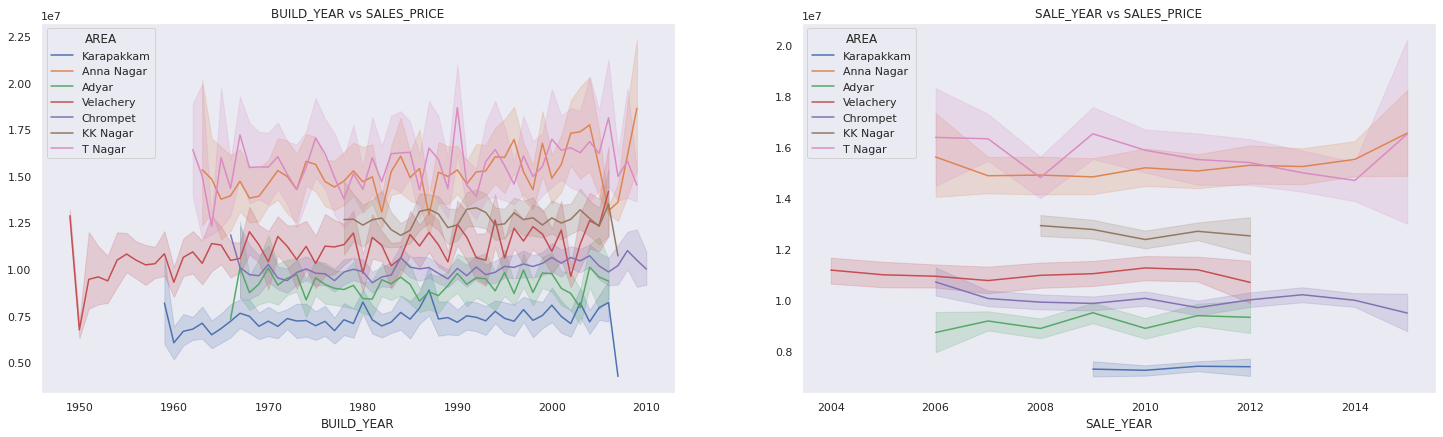

In [30]:
plt.figure(figsize=(25,15))
print('BEFORE INFLATION AND AFTER INFLATION.')
plt.subplot(221)
sns.lineplot(x = "BUILD_YEAR", y = df["SALES_PRICE"].values, data = df,hue='AREA')
plt.title('BUILD_YEAR vs SALES_PRICE')
plt.subplot(222)
sns.lineplot(x = "SALE_YEAR", y = df["SALES_PRICE"].values, data = df,hue='AREA')
plt.title('SALE_YEAR vs SALES_PRICE')
plt.show()

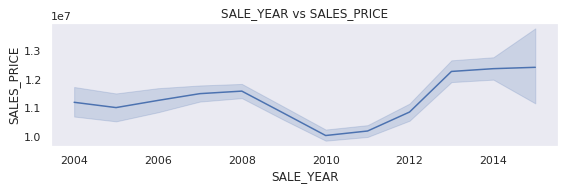

In [33]:
plt.figure(figsize=(20,5))
plt.subplot(221)
sns.lineplot(x = "SALE_YEAR", y = df["SALES_PRICE"], data = df)
plt.title('SALE_YEAR vs SALES_PRICE')
plt.show()

 **EDA**

---



In [34]:
A=df['AREA'].groupby(df['AREA']).count()
B=df['AREA'].groupby(df['BUILDTYPE']).count()
C=df['AREA'].groupby(df['UTILITY_AVAIL']).count()
D=df['AREA'].groupby(df['STREET']).count()
E=df['AREA'].groupby(df['MZZONE']).count()
F=df['AREA'].groupby(df['PARK_FACIL']).count()

BUILDTYPE - Number of "House" building type is higher than "Commercial" and "Other" building type.
AREA - Number of building in "Chrompet" is higher than other area's. "T Nagar" has low number of building when compared with other area's.
UTILITY_AVAILABLE - "NoSewer" building is higher than "ALLPUB" and "ELO" building.

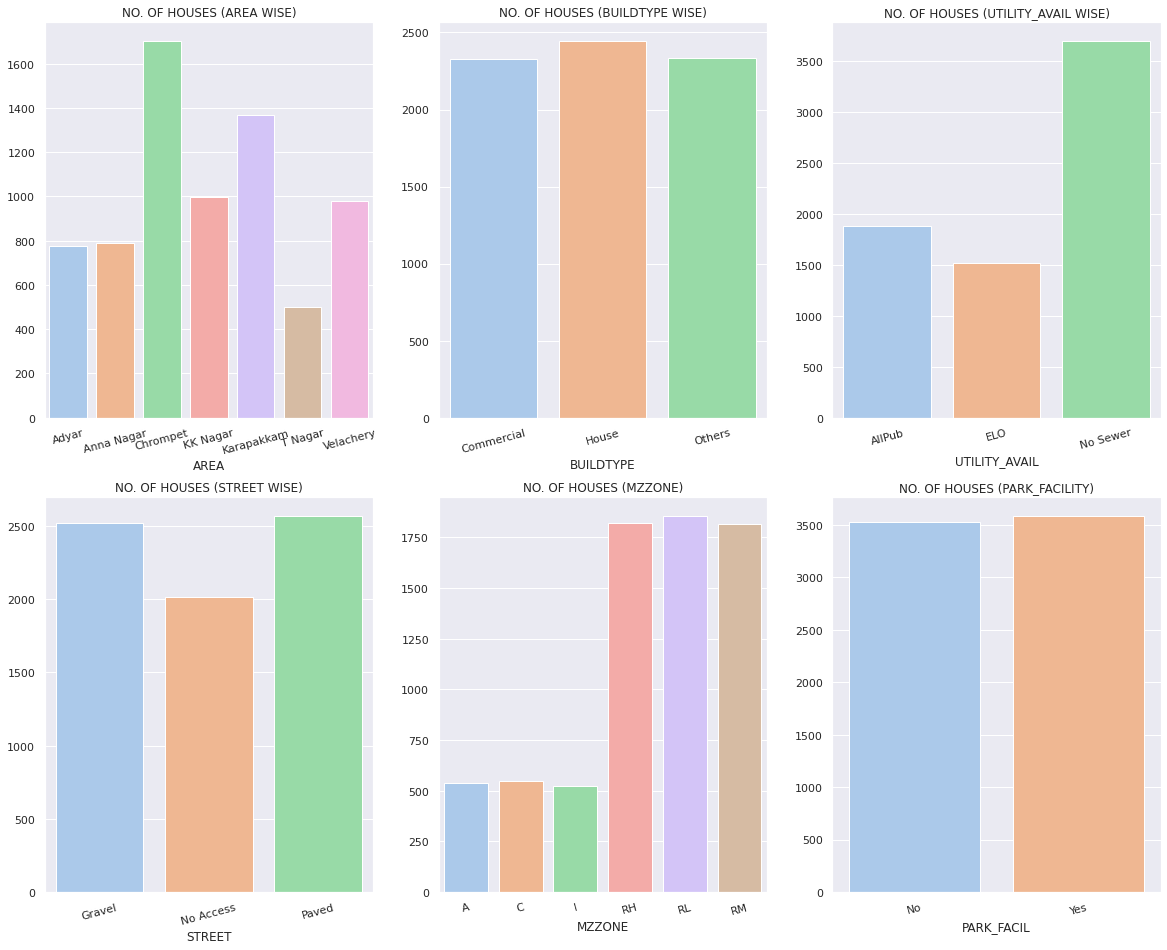

In [35]:
sns.set_theme(style="darkgrid",palette="pastel")
plt.figure(figsize=(20,16))
plt.subplot(231)
sns.barplot(x=A.index,y=A.values,data=df)
plt.xticks(rotation=15)
plt.title('NO. OF HOUSES (AREA WISE)')
plt.subplot(232)
sns.barplot(x=B.index,y=B.values,data=df)
plt.xticks(rotation=15)
plt.title('NO. OF HOUSES (BUILDTYPE WISE)')
plt.subplot(233)
sns.barplot(x=C.index,y=C.values,data=df)
plt.xticks(rotation=15)
plt.title('NO. OF HOUSES (UTILITY_AVAIL WISE)')
plt.subplot(234)
sns.barplot(x=D.index,y=D.values,data=df)
plt.xticks(rotation=15)
plt.title('NO. OF HOUSES (STREET WISE)')
plt.subplot(235)
sns.barplot(x=E.index,y=E.values,data=df)
plt.xticks(rotation=15)
plt.title('NO. OF HOUSES (MZZONE)')
plt.subplot(236)
sns.barplot(x=F.index,y=F.values,data=df)
plt.xticks(rotation=15)
plt.title('NO. OF HOUSES (PARK_FACILITY)')
plt.show()

Target feature VS Others Features

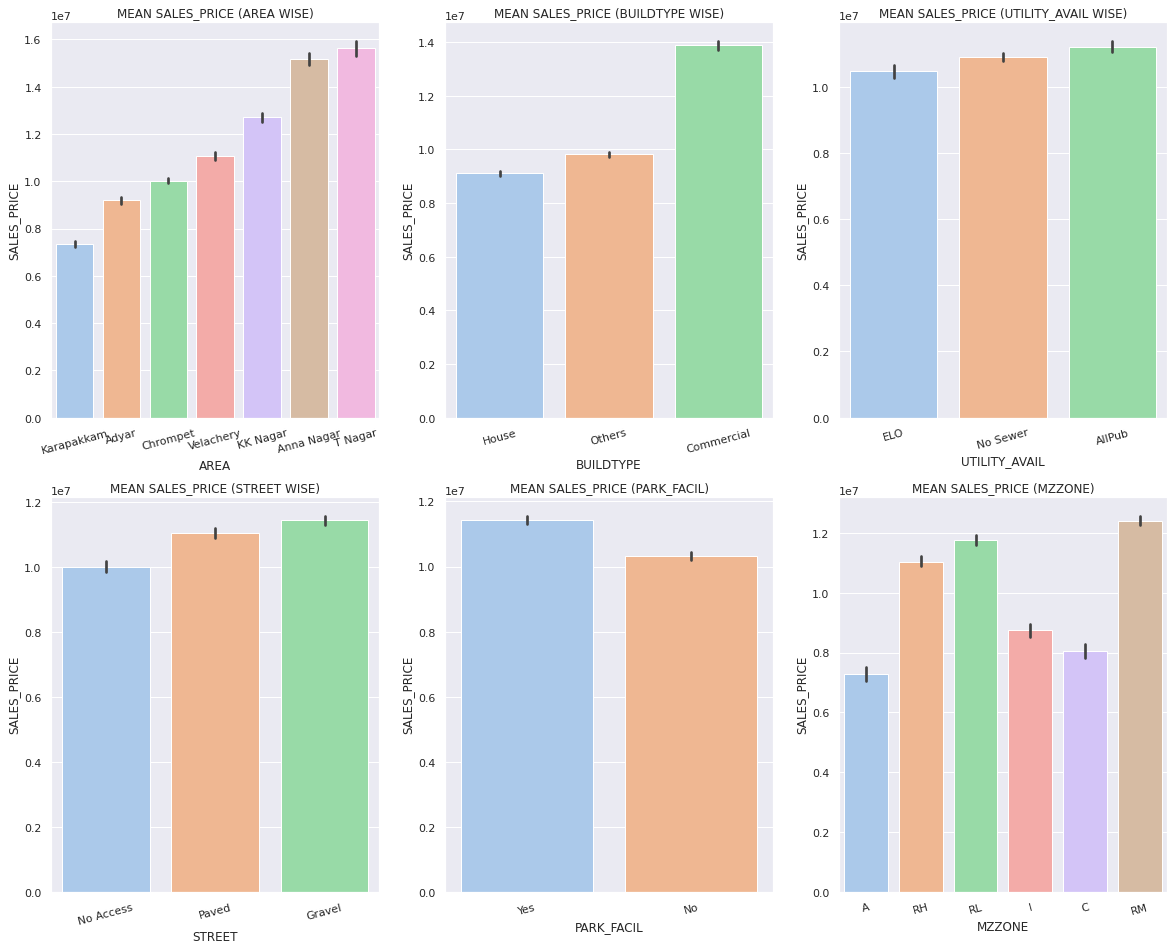

In [36]:
sns.set_theme(style="darkgrid",palette="pastel")
plt.figure(figsize=(20,16))
plt.subplot(231)
sns.barplot(x='AREA',y='SALES_PRICE',data=df,order=df.groupby('AREA')['SALES_PRICE'].mean().reset_index().sort_values('SALES_PRICE')['AREA'])
plt.xticks(rotation=15)
plt.title('MEAN SALES_PRICE (AREA WISE)')
plt.subplot(232)
sns.barplot(x='BUILDTYPE',y='SALES_PRICE',data=df,order=df.groupby('BUILDTYPE')['SALES_PRICE'].mean().reset_index().sort_values('SALES_PRICE')['BUILDTYPE'])
plt.xticks(rotation=15)
plt.title('MEAN SALES_PRICE (BUILDTYPE WISE)')
plt.subplot(233)
sns.barplot(x='UTILITY_AVAIL',y='SALES_PRICE',data=df,order=df.groupby('UTILITY_AVAIL')['SALES_PRICE'].mean().reset_index().sort_values('SALES_PRICE')['UTILITY_AVAIL'])
plt.xticks(rotation=15)
plt.title('MEAN SALES_PRICE (UTILITY_AVAIL WISE)')
plt.subplot(234)
sns.barplot(x='STREET',y='SALES_PRICE',data=df,order=df.groupby('STREET')['SALES_PRICE'].mean().reset_index().sort_values('SALES_PRICE')['STREET'])
plt.xticks(rotation=15)
plt.title('MEAN SALES_PRICE (STREET WISE)')
plt.subplot(235)
sns.barplot(x='PARK_FACIL',y='SALES_PRICE',data=df)
plt.xticks(rotation=15)
plt.title('MEAN SALES_PRICE (PARK_FACIL)')
plt.subplot(236)
sns.barplot(x='MZZONE',y='SALES_PRICE',data=df)
plt.xticks(rotation=15)
plt.title('MEAN SALES_PRICE (MZZONE)')
plt.show()

**Area VS sales Price**

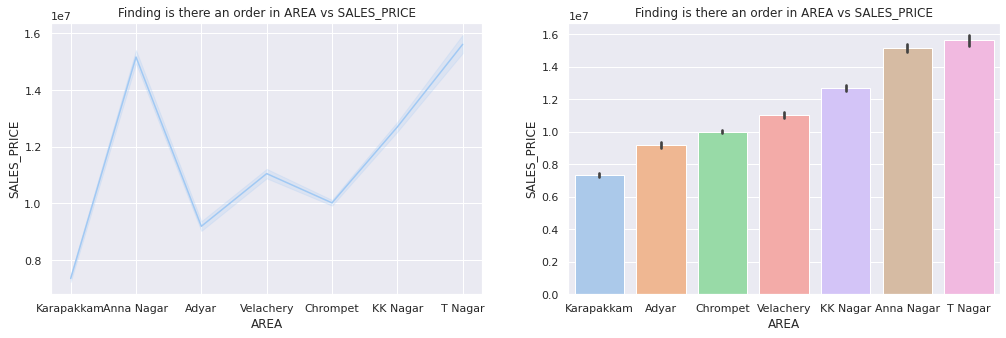

In [38]:
plt.figure(figsize=(17,5))
plt.subplot(121)
sns.lineplot(x=df['AREA'],y=df['SALES_PRICE'])
plt.title('Finding is there an order in AREA vs SALES_PRICE')
plt.subplot(122)
sns.barplot(x='AREA',y='SALES_PRICE',data=df,order=df.groupby('AREA')['SALES_PRICE'].mean().reset_index().sort_values('SALES_PRICE')['AREA'])
plt.title('Finding is there an order in AREA vs SALES_PRICE')
plt.show()

In [39]:
mean=pd.DataFrame(df[['AREA', 'BUILDTYPE','SALES_PRICE']].groupby(['BUILDTYPE','AREA'])['SALES_PRICE'].mean())
median=pd.DataFrame(df[['AREA', 'BUILDTYPE','SALES_PRICE']].groupby(['BUILDTYPE','AREA'])['SALES_PRICE'].median())
max=pd.DataFrame(df[['AREA', 'BUILDTYPE','SALES_PRICE']].groupby(['BUILDTYPE','AREA'])['SALES_PRICE'].max())
min=pd.DataFrame(df[['AREA', 'BUILDTYPE','SALES_PRICE']].groupby(['BUILDTYPE','AREA'])['SALES_PRICE'].min())

In [40]:
mmm_df = pd.concat([min,mean['SALES_PRICE'].rename('Average'),median['SALES_PRICE'].rename('Median'),max['SALES_PRICE'].rename('Maximum')],axis=1)
column =['Minimum','Average','Median','Maximum']
mmm__df = pd.DataFrame(mmm_df)
mmm__df.rename(columns={'SALES_PRICE':'Minimum'},inplace=True)
mmm__df['BUILDTYPE']=['Commercial','Commercial','Commercial','Commercial','Commercial','Commercial','Commercial',
                      'House','House','House','House','House','House','House',
                      'Others','Others','Others','Others','Others','Others','Others']
mmm__df['AREA']=["Adyar","Anna Nagar","Chrompet","KK Nagar","Karapakam","T Nagar","Velachery",
                 "Adyar","Anna Nagar","Chrompet","KK Nagar","Karapakam","T Nagar","Velachery",
                 "Adyar","Anna Nagar","Chrompet","KK Nagar","Karapakam","T Nagar","Velachery"]


**- RESPECTIVE WITH MINIMUM PRICE OF EACH AREA.**
COMMERCIAL - (LOW - HIGH) - Karapakkam area has the lowest price when compared with other area's. Followed with ["Adyar","Chrompet","Velachery","KK Nagar","Anna Nagar","T Nagar"].

"T Nagar" is the first highest according to the "Sales_Price".


HOUSE - (LOW - HIGH) - Again Karapakam area has the lowest price when compared with other area's. Followed with ["Adyar","Chrompet","Velachery","KK Nagar","Anna Nagar","T Nagar"]

Again "T Nagar" is the first highest according to the "Sales_Price".
OTHERS - (LOW - HIGH) - Again Karapakam area has the lowest price when compared with other area's.

Followed with ["Adyar","Chrompet","Velachery","KK Nagar","Anna Nagar","T Nagar"]. Again "T Nagar" is the first highest according to the "Sales_Price".
```



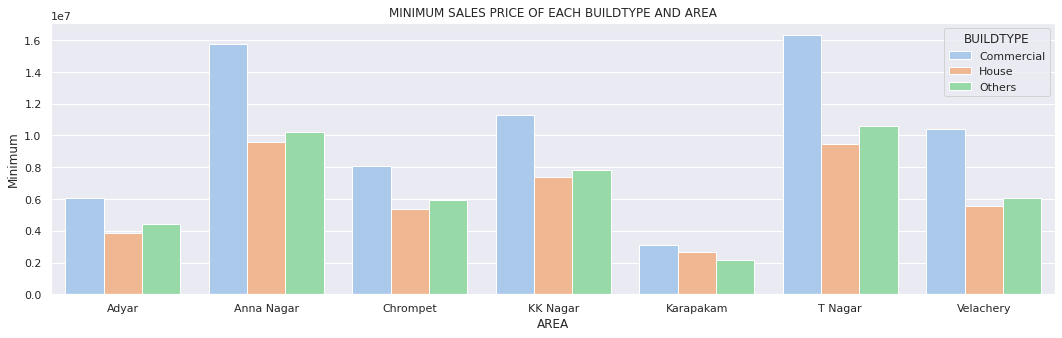

In [41]:
plt.figure(figsize=(18,5))
sns.barplot(x='AREA',y='Minimum',data=mmm__df,hue='BUILDTYPE')
plt.title('MINIMUM SALES PRICE OF EACH BUILDTYPE AND AREA')
plt.show()

**Mean**
COMMERCIAL - (LOW - HIGH) - Karapakkam area has the lowest price when compared with other area's. Followed with ["Adyar","Chrompet","Velachery","KK Nagar","Anna Nagar","T Nagar"]. "T Nagar" is the first highest according to the "Sales_Price".


HOUSE - (LOW - HIGH) - Again Karapakam area has the lowest price when compared with other area's. Followed with ["Adyar","Chrompet","Velachery","KK Nagar""Anna Nagar","T Nagar"]. Again "T Nagar" is the first highest according to the "Sales_Price".


OTHERS - (LOW - HIGH) - Again Karapakam area has the lowest price when compared with other area's. Followed with ["Adyar","Chrompet","Velachery","KK Nagar","Anna Nagar","T Nagar"]. Again "T Nagar" is the first highest according to the "Sales_Price".

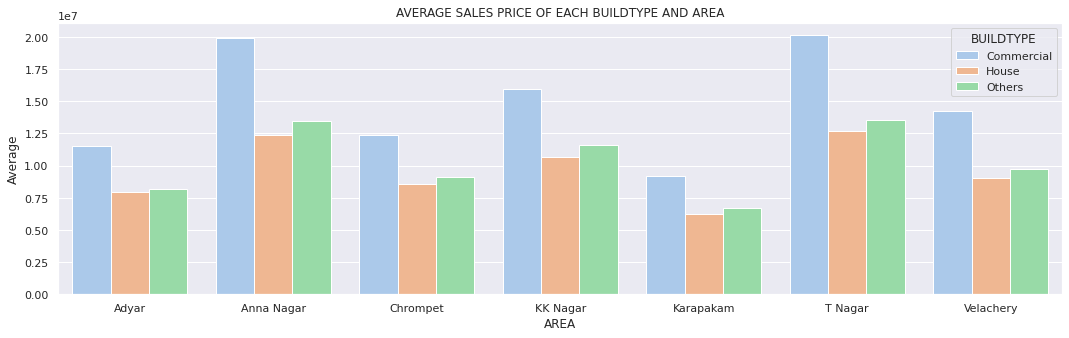

In [42]:
plt.figure(figsize=(18,5))
sns.barplot(x='AREA',y='Average',data=mmm__df,hue='BUILDTYPE')
plt.title('AVERAGE SALES PRICE OF EACH BUILDTYPE AND AREA')
plt.show()

**Maximum Price**

COMMERCIAL - (LOW - HIGH) - Karapakkam area has the lowest price when compared with other area's. Followed with ["Chrompet","Adyar","Velachery","KK Nagar","Anna Nagar","T Nagar"]. "T Nagar" is the first highest according to the "Sales_Price".


HOUSE - (LOW - HIGH) - Again Karapakam area has the lowest price when compared with other area's. Followed with ["Adyar","Chrompet","Velachery","KK Nagar""Anna Nagar","T Nagar"]. Again "T Nagar" is the first highest according to the "Sales_Price".


OTHERS - (LOW - HIGH) - Again Karapakam area has the lowest price when compared with other area's. Followed with ["Adyar","Chrompet","Velachery","KK Nagar","Anna Nagar","T Nagar"]. Again "T Nagar" is the first highest according to the "Sales_Price".


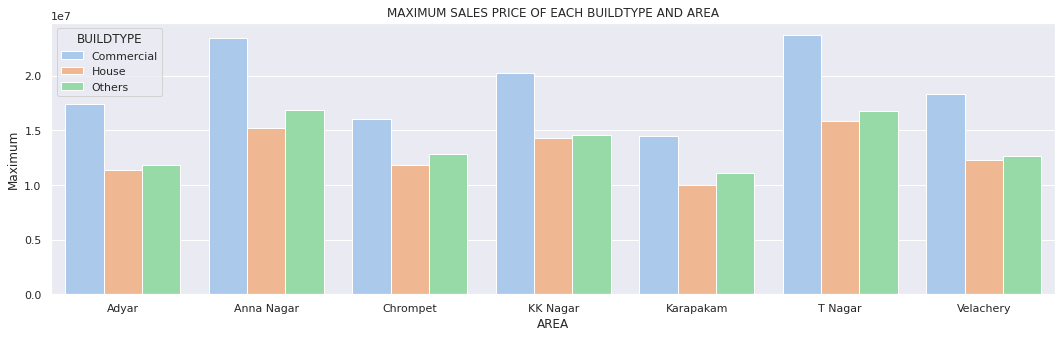

In [43]:
plt.figure(figsize=(18,5))
sns.barplot(x='AREA',y='Maximum',data=mmm__df,hue='BUILDTYPE')
plt.title('MAXIMUM SALES PRICE OF EACH BUILDTYPE AND AREA')
plt.show()

**Encoding the variable**

In [44]:
df.head(2)

,AREA,INT_SQFT,DIST_MAINROAD,N_BEDROOM,N_BATHROOM,N_ROOM,SALE_COND,PARK_FACIL,BUILDTYPE,UTILITY_AVAIL,STREET,MZZONE,SALES_PRICE,Age(Years),BUILD_YEAR,SALE_YEAR,SOLD_AGE
0,Karapakkam,1004,131,1.0,1.0,3,AbNormal,Yes,Commercial,AllPub,Paved,A,7600000,43,1967,2011,44
1,Anna Nagar,1986,26,2.0,1.0,5,AbNormal,No,Commercial,AllPub,Gravel,RH,21717770,10,1995,2006,11


In [45]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()

In [46]:
df['PARK_FACIL']=le.fit_transform(df['PARK_FACIL'])
df['AREA']=le.fit_transform(df['AREA'])
df['BUILDTYPE']=le.fit_transform(df['BUILDTYPE'])
df['SALE_COND']=le.fit_transform(df['SALE_COND'])
df['UTILITY_AVAIL']=le.fit_transform(df['UTILITY_AVAIL'])
df['STREET']=le.fit_transform(df['STREET'])
df['MZZONE']=le.fit_transform(df['MZZONE'])

**Correlation of the feature**

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2, f_regression
from scipy.stats import pearsonr

In [48]:
X=df.drop(['SALES_PRICE'],axis=1)
y=df['SALES_PRICE']

In [49]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5687, 16), (1422, 16), (5687,), (1422,))

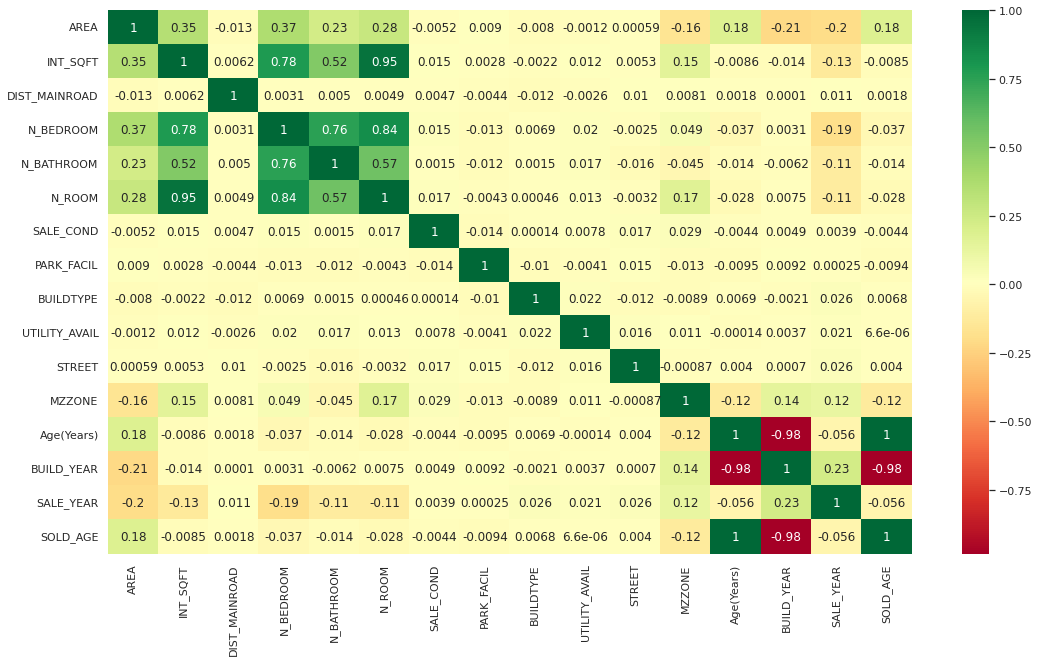

In [50]:
import seaborn as sns
#Using Pearson Correlation
plt.figure(figsize=(18,10))
cor = X_train.corr()
sns.heatmap(cor, annot=True,cmap='RdYlGn')
plt.show()

In [51]:
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are use absolute() to even focus on -ve coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [52]:
corr_features = correlation(X_train, 0.8)
len(set(corr_features))
print('This column are highly correlated with another column:',corr_features)

This column are highly correlated with another column: {'N_ROOM', 'SOLD_AGE', 'BUILD_YEAR'}


In [53]:
cwf_train=X_train.drop(corr_features,axis=1)
cwf_test=X_test.drop(corr_features,axis=1)

In [54]:
cwf_train.shape

(5687, 13)

In [55]:
train = pd.concat([cwf_train,y_train],axis=1)
test = pd.concat([cwf_test,y_test],axis=1)

In [57]:
new_df=pd.concat([train,test],axis=0)
new_df.shape
print("PREVIOUSLY THE NO. OF FEATURE IS:",df.shape)
print("NOW THE NO. OF FEATURE IS:",new_df.shape)
print("{} ".format(df.shape[1]-new_df.shape[1]))

PREVIOUSLY THE NO. OF FEATURE IS: (7109, 17)
NOW THE NO. OF FEATURE IS: (7109, 14)
3 


,AREA,INT_SQFT,DIST_MAINROAD,N_BEDROOM,N_BATHROOM,SALE_COND,PARK_FACIL,BUILDTYPE,UTILITY_AVAIL,STREET,MZZONE,Age(Years),SALE_YEAR,SALES_PRICE
SALES_PRICE,-0.019138,0.612125,0.018783,0.330987,0.108834,-0.030732,0.146428,-0.436276,-0.023812,-0.042652,0.427789,-0.119037,0.000906,1.0


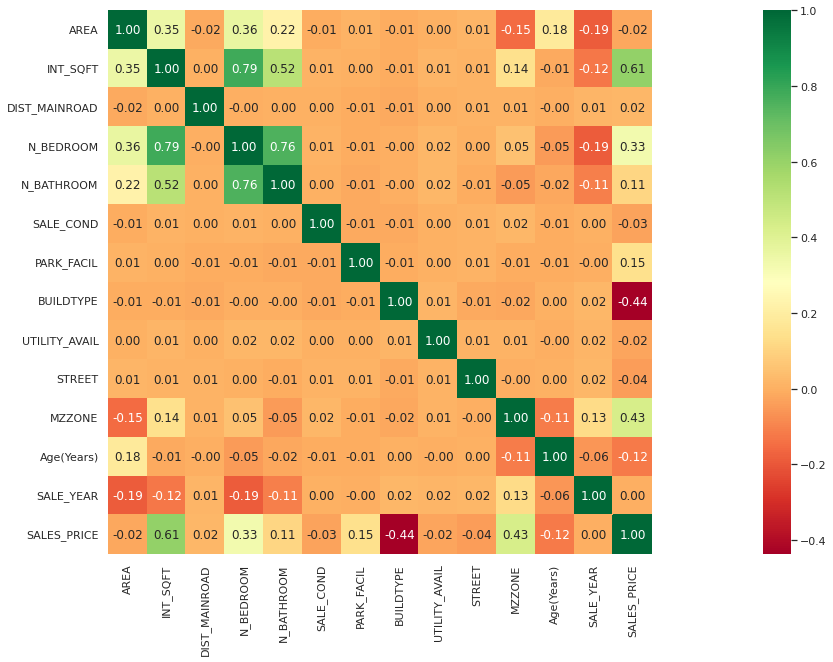

In [58]:
corrmat = new_df.corr()
plt.figure(figsize=(40, 10))
sns.heatmap(corrmat, cbar=True, fmt='.2f', annot=True, cmap='RdYlGn', square=True)
i=pd.DataFrame(new_df[new_df.columns[:]].corr()['SALES_PRICE'][:]).T
i=i.iloc[0]
pd.DataFrame(i).T

In [59]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2, f_regression
from scipy.stats import pearsonr
scaler=StandardScaler()
minmax=MinMaxScaler()

In [60]:
X=new_df.drop(['SALES_PRICE'],axis=1)
y=new_df['SALES_PRICE']

In [61]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5687, 13), (1422, 13), (5687,), (1422,))

In [62]:
best_features_X = SelectKBest(score_func=f_regression,k=10).fit_transform(X,y)

In [64]:
print(best_features_X)

[[1.155e+03 1.000e+00 1.000e+00 ... 0.000e+00 3.000e+00 3.400e+01]
 [1.785e+03 1.000e+00 1.000e+00 ... 0.000e+00 3.000e+00 3.700e+01]
 [5.850e+02 1.000e+00 1.000e+00 ... 1.000e+00 1.000e+00 1.600e+01]
 ...
 [1.438e+03 2.000e+00 2.000e+00 ... 0.000e+00 0.000e+00 3.300e+01]
 [1.267e+03 2.000e+00 1.000e+00 ... 1.000e+00 4.000e+00 2.300e+01]
 [1.721e+03 2.000e+00 1.000e+00 ... 2.000e+00 3.000e+00 2.100e+01]]


In [65]:
correlation_list=[]
for column in X.columns:
  corr_list=pearsonr(X[column],y)
  correlation_list.append([column,corr_list[0],corr_list[1]])

In [66]:
corr_df=pd.DataFrame(correlation_list,columns=['Features','Correlation','P-Value'])
corr_df.sort_values(by='P-Value',inplace=True)
corr_df.T

,1,7,10,3,6,11,4,9,5,8,0,2,12
Features,INT_SQFT,BUILDTYPE,MZZONE,N_BEDROOM,PARK_FACIL,Age(Years),N_BATHROOM,STREET,SALE_COND,UTILITY_AVAIL,AREA,DIST_MAINROAD,SALE_YEAR
Correlation,0.612125,-0.436276,0.427789,0.330987,0.146428,-0.119037,0.108834,-0.042652,-0.030732,-0.023812,-0.019138,0.018783,0.000906
P-Value,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000322,0.00956,0.044681,0.106634,0.113289,0.939123


In [67]:
model_training_feature1 = corr_df['Features']
model_training_feature1 = model_training_feature1.to_list()
model_training_feature = corr_df['Features']
model_training_feature = model_training_feature.to_list()
model_training_feature

['INT_SQFT',
 'BUILDTYPE',
 'MZZONE',
 'N_BEDROOM',
 'PARK_FACIL',
 'Age(Years)',
 'N_BATHROOM',
 'STREET',
 'SALE_COND',
 'UTILITY_AVAIL',
 'AREA',
 'DIST_MAINROAD',
 'SALE_YEAR']

In [68]:
new_df = pd.DataFrame(new_df,columns=model_training_feature)
new_df=pd.concat([new_df,df['SALES_PRICE']],axis=1)

### **Machine Learning Model**

In [69]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xg
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
scaler=StandardScaler()
minmax=MinMaxScaler()

In [70]:
X=new_df.drop('SALES_PRICE',axis=1)
y=df['SALES_PRICE']

In [71]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5687, 13), (1422, 13), (5687,), (1422,))

In [72]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Linear Regression

In [73]:
from sklearn.linear_model import LinearRegression
lr_model=LinearRegression()

In [76]:
lr_model.fit(X_train,y_train)
lr_y_pred=lr_model.predict(X_test)
print(r2_score(y_test,lr_y_pred))

0.7737268714063561


# XGBOOST

In [77]:
import xgboost as xg
# xg_model = XGBRegressor()
xg_model= xg.XGBRegressor(colsample_bytree=0.4,
                 gamma=2,                 
                 learning_rate=0.01,
                 max_depth=4,
                 min_child_weight=1.5,
                 n_estimators=10000,                                                                    
                )

In [78]:
xg_model.fit(X_train_scaled,y_train)

[09:31:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(colsample_bytree=0.4, gamma=2, learning_rate=0.01, max_depth=4,
             min_child_weight=1.5, n_estimators=10000)

In [79]:
xg_y_pred=xg_model.predict(X_test_scaled)

In [80]:
print("XGBoost model Rsquared metric:",r2_score(y_test,xg_y_pred))

XGBoost model Rsquared metric: 0.9989374636414392


# RANDOM FOREST REGRESSOR

In [81]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor

# Instantiate model 
rf = RandomForestRegressor(n_estimators= 1000, max_depth = 4, max_features='sqrt')

# Train the model on training data
rf.fit(X_train, y_train);

# Use the forest's predict method on the test data
rf_pred = rf.predict(X_test)

In [82]:
print("Random forest Regressor model Rsquared metric",r2_score(y_test,rf_pred))

Random forest Regressor model Rsquared metric 0.77986324712636


In [84]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xg

model1 = LinearRegression()
model2 = RandomForestRegressor(random_state=1)
model3 = GradientBoostingRegressor(random_state=1)
model4 = DecisionTreeRegressor(random_state=1)
model = VotingRegressor(estimators=[('Linear_Regg', model1), ('Random_Forest', model2), ('Gradient_Boosting', model3)])
model.fit(X_train,y_train)
et_y_pred=model.predict(X_test)
print("Ensemble Technique Rsquared metric",r2_score(y_test,et_y_pred))

Ensemble Technique Rsquared metric 0.9590533798959517


In [85]:
print("XGBoost model Rsquared metric:",r2_score(y_test,xg_y_pred))
print("Ensemble Technique Rsquared metric:",r2_score(y_test,et_y_pred))
print("Random forest Regressor model Rsquared metric:",r2_score(y_test,rf_pred))
print("Linear Regg model Rsquared metric:",r2_score(y_test,lr_y_pred))

XGBoost model Rsquared metric: 0.9989374636414392
Ensemble Technique Rsquared metric: 0.9590533798959517
Random forest Regressor model Rsquared metric: 0.77986324712636
Linear Regg model Rsquared metric: 0.7737268714063561


# Suggestion

Before answering them. I would like to ask them whether they have any expections/wishes regarding the build type,location, price,...utility?
**ANSWER OF BUYERS**
He wants to buy a "HOUSE" building with all amenities.


**ANSWER TO BUYERS**
I would let him know that the average sales_price of "house" building is lesser than "Others" & "Commercial" type buildings. 

When it comes to the location i would suggest my buyer to buy in Karapakam, because the price of price and also it is near to the beach.
Minmum price = 26,40,250.00
Average price = 62,66,439.00
Maximum price = 99,66,750.00 


The Maximum price of "House" building in karapakkam is 9966750.00(Ninty nine lakhs sixty six thousand seven fifty) and the average price is 62,66,439.00(sixty two lakhs sixty six thousand four hundred and thirty nine). Since the buyer need with all amenity,


 he/she can negotiate the price between (90,00,000 - 95,00,000).